In [172]:
!git clone https://github.com/beckhamtoh/char-llm-assignment.git
%cd char-llm-assignment

Cloning into 'char-llm-assignment'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 21 (delta 3), reused 11 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (21/21), 30.18 MiB | 37.92 MiB/s, done.
Resolving deltas: 100% (3/3), done.
/content/char-llm-assignment/char-llm-assignment/char-llm-assignment/char-llm-assignment/char-llm-assignment/char-llm-assignment


In [173]:
# Enable autoreload of local Python modules (e.g., models)
# %load_ext autoreload
# %autoreload 2

# manual reload for local modules
import importlib

**the only change i did was to import matplotlib for plotting**

In [174]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import jax
import jax.numpy as jnp
import optax
import time
import matplotlib.pyplot as plt

# local imports
import models.models as models
import util.generation as generation


In [175]:
# initialize the jax random key
key = jax.random.key(0)

# Load data

**no change**

In [176]:
# load the ./data/text8_train.txt and ./data/text8_test.txt files
with open("./data/text8_train.txt", "r") as f:
    train_text = f.read()
with open("./data/text8_test.txt", "r") as f:
    test_text = f.read()

# print the length of the training text and test text
print(f"Length of training text: {len(train_text):_} characters")
print(f"Length of test text: {len(test_text):_} characters")

Length of training text: 90_000_000 characters
Length of test text: 5_000_000 characters


In [177]:
# Build vocabulary (lowercase + space + a few punctuations)
char_set = list("abcdefghijklmnopqrstuvwxyz ")
char_to_int = {ch:i for i,ch in enumerate(char_set)}
int_to_char = {i:ch for ch,i in char_to_int.items()}

def encode(s):
    """Encode string to array of integers"""
    ids = [char_to_int[c] for c in s]
    return np.array(ids, dtype=np.uint8)  # use np.uint8 to save space

In [178]:
# encode the text
train_text_int = encode(train_text)
test_text_int = encode(test_text)

In [179]:
# sanity check: display a few random characters from the training text
T = 128
for _ in range(5):
    # choose random position in text
    N = np.random.randint(low=0, high=len(train_text)-T)
    print(train_text[N:N+T])
    print()

id by fux s contemporaries to be in palestrina style indeed fux s treatise is a rather accurate compendeum of palestrina s techn

t in the downtown core which was rebuilt in neoclassical style to resemble st petersburg like elsewhere technological advancemen

i ir t mar novel one nine three five r ur gamli halti short stories see ttir one nine three seven daglei fj llum articles one ni

e and the country a frieze on the facade of the supreme court building depicts the figure of a roman centurion holding a fasces 

evolutions of revolutionary parties that for ideologic or pragmatic reasons came to embrace a strategy of gradual change through



# Create a basic Transformer model

d_ff: the feedforward dimension inside each encoder / decoder block (allows the network to learn more complex and non-linear transformations of the data from the attention layers)

dropout_rate: for regularization

add positional encoding - learned or sinusoidal positional embeddings (2 methods for a model to undertsand the order of tokens in a sequence)

k_future: allow predicting multiple future tokens --> loss function can be modified to compute only the last token or last k_future tokens for better long-term dependency learning

**not supported???**

In [180]:
def create_train_state(rng, vocab_size = 27, d_model = 256, n_layers = 2, n_heads = 8, max_len = 128):
    model = models.DecoderOnlyTransformer(
        vocab_size=vocab_size, d_model=d_model, n_layers=n_layers, n_heads=n_heads, max_len=max_len
    )
    dummy = jnp.zeros((1, max_len), dtype=jnp.int32)
    params = model.init({"params": rng}, dummy)["params"]
    return model, params

prof's code:

In [ ]:
def create_train_state(rng, vocab_size=27, d_model=64, n_layers=6, n_heads=8, max_len=128):
    # create a basic Transformer model
    model = models.DecoderOnlyTransformer(vocab_size, d_model, n_layers, n_heads, max_len)
    # create a dummy input for initialization
    dummy = jnp.zeros((1, min(16, max_len)), dtype=jnp.int32)
    # pass the dummy input to the model to initialize the parameters
    params = model.init({"params": rng}, dummy)["params"]
    return model, params

comparison:

dummy sequence uses max length --> ensures initialization will correctly allocate all positional embeddings for the intended sequence length (subtle)

- positional embeddings: vectors added to the input embeddings of a model, like a transformer, to give it information about the order of tokens in a sequence

changes model dimensions



---


no change:

In [181]:
# vocab size
vocab_size= len(char_set)

# internal model dimensions
d_model=256

# number of attention heads
n_heads=8

# number of Transformer layers
n_layers=2

# maximum sequence length
max_len=128

model, params = create_train_state(key, vocab_size, d_model, n_layers, n_heads, max_len)

In [182]:
# compute the number of parameters
def count_params(params):
    return sum(x.size for x in jax.tree_util.tree_leaves(params))
print(f"Number of parameters: {count_params(params):_}")

Number of parameters: 1_624_576


In [183]:
# sanity check: create a batch of data & run a forward pass
B, T = 4, 32
batch = jax.random.randint(
    key=key,
    shape=(B, T), minval=0, maxval=len(char_set))
logits = model.apply({"params": params}, batch)

print("batch shape:", batch.shape)  # (B, T)
print("logits shape:", logits.shape)  # (B, T, vocab_size)

batch shape: (4, 32)
logits shape: (4, 32, 27)


# Loss function

compute the loss only on the last token of each sequence: long-term dependencies (currently: loss is averaged over all positions --> model is equally penalized for mistakes at the beginning, middle and end of the sequence) improvement: focuses the gradient on long-range dependencies and sequence-level learning (useful when you want the model to look further back in the sequence rather than just copy nearby tokens)

extend this idea by predicting the last k tokens (k > 1): model still gets focused training on the final steps of the sequence, gradients for early tokens in the block are still computed indirectly via attention, but the loss signal is stronger for the part of the sequence we care about

**not supported???**

label smoothing --> for smoother probability distributions and better generalization (prevent overconfidence)

In [184]:
@jax.jit
def loss_and_metrics(logits, targets, label_smoothing = 0.1):
    B, T, V = logits.shape

    # flatten batch and sequence for loss
    flat_logits = logits.reshape(-1, V)
    flat_targets = targets.reshape(-1)

    # label smoothing
    one_hot = jax.nn.one_hot(flat_targets, V)
    smoothed = one_hot * (1 - label_smoothing) + label_smoothing / V
    log_probs = jax.nn.log_softmax(flat_logits)
    loss = -jnp.sum(smoothed * log_probs, axis = -1).mean()

    # predictions
    preds = jnp.argmax(logits, axis = -1)
    acc_all = jnp.mean((preds == targets).astype(jnp.float32))
    acc_last = jnp.mean((preds[:, -1] == targets[:, -1]).astype(jnp.float32))

    metrics = {"loss": loss, "acc_all": acc_all, "acc_last": acc_last}
    return loss, metrics

loss_and_metrics = jax.jit(loss_and_metrics, static_argnames=("label_smoothing",))

prof's code:

In [ ]:
@jax.jit
def loss_and_metrics(logits, targets):
    """Compute cross-entropy loss and accuracy.

    Assumes `targets` contains only valid integer class ids in [0, V-1] (no -1 ignore tokens).

    Args:
      logits: (B, T, V) float array of unnormalized scores.
      targets: (B, T) integer array with ground-truth class ids.

    Returns:
      loss: scalar average cross-entropy over all positions.
      metrics: dict with keys "loss" and "acc" (both scalars).
    """
    # Flatten batch/time dims so optax works on shape (N, V) and (N,)
    vocab = logits.shape[-1]
    flat_logits = logits.reshape(-1, vocab)
    flat_targets = targets.reshape(-1)

    # Per-position cross-entropy, then mean over all positions
    per_pos = optax.softmax_cross_entropy_with_integer_labels(flat_logits, flat_targets)
    loss = per_pos.mean()

    # prediction over all positions
    preds = jnp.argmax(logits, axis=-1)  # (B, T)

    # compute accuracy over only the last position
    is_match = preds == targets

    # Accuracy over all positions
    acc_all = jnp.mean(is_match.astype(jnp.float32))

    # Accuracy over only last position
    acc_last = jnp.mean(is_match.astype(jnp.float32)[:,-1])

    return loss, {"loss": loss, "acc": acc_all, "acc_last": acc_last}

# Optimization step:

add gradient clipping (rationale: to solve the following problem - large transformers can have unstable gradients)

In [185]:
def train_step(params, opt_state, x, y, tx, model, label_smoothing = 0.1):
    def loss_fn(params):
        logits = model.apply({"params": params}, x)
        return loss_and_metrics(logits, y, label_smoothing = label_smoothing)

    (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux = True)(params)

    # Do NOT clip manually; already handled by tx
    updates, new_opt_state = tx.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, metrics

train_step = jax.jit(train_step, static_argnames = ("tx", "model", "label_smoothing"))

prof's code:

In [ ]:
# create an update function
def train_step(params, opt_state, x, y, tx):
    """Single optimization step using optax optimizer.

    Args:
      params: pytree of model parameters.
      opt_state: optax optimizer state corresponding to `params`.
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
      tx: optax.GradientTransformation (already initialized).

    Returns:
      new_params: updated parameters after one gradient step.
      new_opt_state: updated optimizer state.
      metrics: dict of scalar metrics (loss, acc).
    """
    def loss_fn(params):
        logits = model.apply({"params": params}, x)
        loss, metrics = loss_and_metrics(logits, y)
        return loss, metrics

    # compute gradients (loss is scalar, metrics is auxiliary)
    (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)

    # optax update: compute parameter updates and new optimizer state
    updates, new_opt_state = tx.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, metrics

# jit: last argument should be static because it is an object
train_step = jax.jit(train_step, static_argnames=("tx",))

# Batch creation:

add k parameter to predict multiple future tokens (currently: always create targets of length T) **not supported**

minor diff: ix = np.random.randint(0, len(text_int) - T - 1, size = B)
- ensures never go out of bounds (-1)

In [186]:
def get_batch(text_int, B, T):
    ix = np.random.randint(0, len(text_int) - T - 1, size = B)
    x = np.stack([text_int[i : i+T] for i in ix])
    y = np.stack([text_int[i+1 : i+T+1] for i in ix])
    return jnp.array(x, dtype = jnp.int32), jnp.array(y, dtype = jnp.int32)

prof's code:

In [ ]:
# create a batch from the training data
def get_batch(text_int, B, T):
    """Create a random batch of data from text_int.

    Args:
      text_int: 1D array of token ids.
      B: batch size (number of sequences).
      T: sequence length (number of tokens per sequence).

    Returns:
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
    """
    # choose random starting indices for each sequence in the batch
    ix = np.random.randint(0, len(text_int) - T, size=B)
    # inputs are text from i to i+T
    x = np.stack([text_int[i:i+T] for i in ix])
    # targets are text from i+1 to i+T+1
    y = np.stack([text_int[i+1:i+T+1] for i in ix])
    return jnp.array(x, dtype=jnp.int32), jnp.array(y, dtype=jnp.int32)

# Optimizer creation:

In [187]:
learning_rate = 0.001
B, T = 128, 32
B_test, T_test = 256, 32
niter = 100_000
k_future = 3
label_smoothing = 0.1
max_grad_norm = 1.0
dtype = jnp.float32

key = jax.random.PRNGKey(0)
model, params = create_train_state(key, vocab_size = len(char_set), d_model = 256,
                                   n_layers = 2, n_heads = 8, max_len = 128)

tx = optax.chain(
    optax.clip_by_global_norm(max_grad_norm),
    optax.adam(learning_rate)
)
opt_state = tx.init(params)

prof's code:

In [ ]:
# define optax optimizer
learning_rate = 0.001
# Create Adam optimizer (Optax)
tx = optax.adam(learning_rate=learning_rate)
# Initialize optimizer state for current params
opt_state = tx.init(params)
print(f"Initialized optimizer: Adam lr={learning_rate}")

clip_by_global_norm(max_grad_norm) → gradient clipping

Effect: Gradients are clipped before being applied by Adam.

More robust for training stability, especially for Transformers, which can have exploding gradients.

In [189]:
history = {"train_loss": [], "test_loss": [], "train_acc": [], "test_acc": [], "time": []}
time_start = time.time()

for it in range(niter):
    # Sample batch
    x, y = get_batch(train_text_int, B, T)

    # Training step
    params, opt_state, metrics = train_step(
        params, opt_state, x, y, tx, model,
        label_smoothing = label_smoothing
    )

    # Logging
    loss_train = metrics["loss"]
    acc_train = metrics["acc_all"]
    history["train_loss"].append(loss_train)
    history["train_acc"].append(acc_train)
    history["time"].append(time.time() - time_start)

    # Periodic evaluation
    if it % (niter // 50) == 0 or it == niter - 1:
        test_x, test_y = get_batch(test_text_int, B_test, T_test)
        test_logits = model.apply({"params": params}, test_x)
        test_loss, test_metrics = loss_and_metrics(test_logits, test_y, label_smoothing = label_smoothing)
        acc_test = test_metrics["acc_all"]

        history["test_loss"].append(test_loss)
        history["test_acc"].append(acc_test)

        print(f"Iter {it:_} | Time: {time.time()-time_start:.1f}s | "
              f"Loss(train:test): {loss_train:.4f}:{test_loss:.4f} | "
              f"Acc(train:test): {100*acc_train:.1f}%:{100*acc_test:.1f}%")

Iter 0 | Time: 24.6s | Loss(train:test): 3.9329:3.6177 | Acc(train:test): 2.1%:17.1%
Iter 2_000 | Time: 27.3s | Loss(train:test): 1.8208:1.8423 | Acc(train:test): 55.1%:53.5%
Iter 4_000 | Time: 30.7s | Loss(train:test): 1.7845:1.8236 | Acc(train:test): 56.1%:54.8%
Iter 6_000 | Time: 33.7s | Loss(train:test): 1.7852:1.8035 | Acc(train:test): 56.2%:55.1%
Iter 8_000 | Time: 36.9s | Loss(train:test): 1.7538:1.7504 | Acc(train:test): 57.8%:57.1%
Iter 10_000 | Time: 40.0s | Loss(train:test): 1.7167:1.7585 | Acc(train:test): 58.6%:57.6%
Iter 12_000 | Time: 43.2s | Loss(train:test): 1.7557:1.7771 | Acc(train:test): 56.5%:56.4%
Iter 14_000 | Time: 46.5s | Loss(train:test): 1.7348:1.7420 | Acc(train:test): 58.4%:57.5%
Iter 16_000 | Time: 49.7s | Loss(train:test): 1.7203:1.7601 | Acc(train:test): 57.5%:56.4%
Iter 18_000 | Time: 52.9s | Loss(train:test): 1.7231:1.7435 | Acc(train:test): 57.6%:57.8%
Iter 20_000 | Time: 55.9s | Loss(train:test): 1.7716:1.7404 | Acc(train:test): 56.7%:57.2%
Iter 22_0

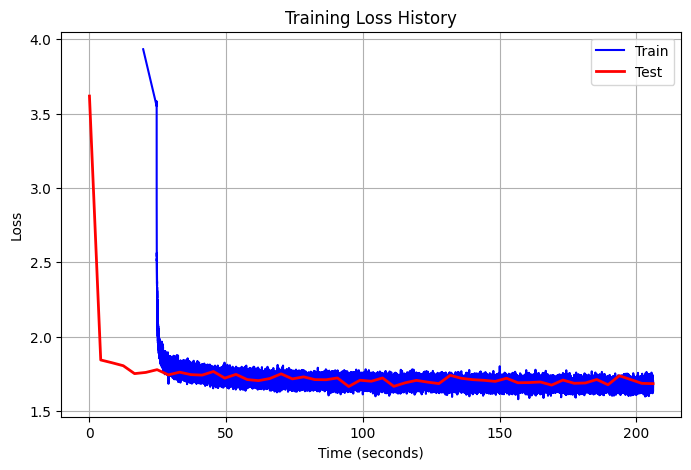

In [192]:
# Convert history lists to arrays for convenience
train_time = np.array(history["time"])
train_loss = np.array(history["train_loss"])

# Test loss was recorded less frequently
test_loss = np.array(history["test_loss"])
test_acc = np.array(history["test_acc"])

# Calculate corresponding time points for test_loss
n_test_points = len(test_loss)
# The test points correspond to every niter//50 iterations
test_time_indices = np.linspace(0, train_time[-1], n_test_points)

plt.figure(figsize = (8,5))
plt.plot(train_time, train_loss, '-', label = 'Train', color = "blue")
plt.plot(test_time_indices, test_loss, '-', label = 'Test', color = "red", lw = 2)
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend(loc = 'upper right')
plt.grid(True)
plt.show()

In [193]:
B = 1
seed = 42
rng = jax.random.PRNGKey(seed)

prompt = "hello my fri"

# Convert prompt to integer IDs (fallback to 0 if char not found)
prompt_int = jnp.array([[char_to_int.get(c, 0) for c in prompt.lower()[:64]]], dtype=jnp.int32)

gen_len = 1000

# Generate tokens
out_ids = generation.generate_tokens(
    model, params, rng, prompt_int, gen_len,
    block_size = 64,  # or max_len depending on your function
    temperature = 0.7,
    sample = True
)

print('Generated IDs shape:', out_ids.shape)

# Convert IDs back to text
generated_text = ''.join(int_to_char.get(int(x), '?') for x in out_ids[0])
print('Generated text:')
print(prompt + generated_text)  # concatenate with prompt

Generated IDs shape: (1, 1000)
Generated text:
hello my fri il stin wo wa a h sh ad dep ralenighanaleiffff palanearzarectonoriedonis wm aoreule ondel me ialalar i s th s aligardriliayskef wanyngaledour bojamabiches ch oteik ram s arubear waran ithon othk sothan athelflesoks reim t ke fedopp m tomasitreonethascolethareely wanig ponghet tched t dile abr evif ckuledoqumali o han tha iczemilie pan fff blinanesoneis ireedx ms drinin c achies l s ous ma fleigges tocothams addiescajon abe wat heleinaxim dito s o ace cinedokhereale teichedeje one h ie warho asthkyoredrarithonem ign s this dima t s th a poud wazamanamaneay th leshughatretoumarervi s oy ak prenalin ry is rs ch alyanonevezubudo tonespanesealorinonedoule anicialin buiato ar ys ick in s fumale c a posalineuchon shitethorvilarirablatzgaker talayne les hed cecati ane s amidan ens distpononerileschestore wamaberanagnaro dsherlyriurts arane m e shalidesett wis ch iorale hotonigimetst aneyreindenuches eighe t wa i arotary id jilyor figh